In [5]:
import pickle
import numpy as np
import pandas as pd
from pprint import pprint

#visualisation packages
import matplotlib.pyplot as plt
import seaborn as sns

#Modelling packages
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ShuffleSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
#Importing Data set
data_path = "/Users/dorothyjeyson/Kaggle/Text_classification/Data/"

#Dataframe
with open(data_path+"Preprocessed.pickle", "rb") as data:
    df = pickle.load(data)
    
#Features_Train
with open(data_path+"features_train.pickle", "rb") as data:
    features_train = pickle.load(data)

#Labels_Train
with open(data_path+"labels_train.pickle", "rb") as data:
    labels_train = pickle.load(data)

#Features_Test
with open(data_path+"features_test.pickle", "rb") as data:
    features_test = pickle.load(data)
    
#Labels_Test
with open(data_path+"labels_test.pickle", "rb") as data:
    labels_test = pickle.load(data)

Let's check the dimension of our feature vectors:

In [3]:
print(features_train.shape)
print(features_test.shape)

(1796, 300)
(317, 300)


### Cross Validation for hyperparameter tuning

Let's look at the model hyperparameters(in our case logistic regression)

In [6]:
log_reg = LogisticRegression(random_state=8)

print("Parameters currently in use: ")
pprint(log_reg.get_params())

Parameters currently in use: 
{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 8,
 'solver': 'warn',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


We'll tune the following ones:

- C = Inverse of regularization strength. Smaller values specify stronger regularization.
- multi_class = We'll choose multinomial because this is a multi-class problem.
- solver = Algorithm to use in the optimization problem. For multiclass problems, only newton-cg, sag, saga and lbfgs handle multinomial loss.
- class_weight: Weights associated with classes.
- penalty: Used to specify the norm used in the penalization. The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties.

### Randomized Search Cross Validation

We first need to define the grid:

In [7]:
C = [float(x) for x in np.linspace(start = 0.1, stop=1.0, num = 10)]

#multi_class
multi_class = ['multinomial']

#solver
solver = ['newton-cg','sag','saga','lbfgs']

#class_weight
class_weight = ['balanced',None]

#penalty
penalty = ['l2']

#create random grid
random_grid = {'C':C,
              'multi_class':multi_class,
              'solver':solver,
              'class_weight':class_weight,
              'penalty':penalty
              }
pprint(random_grid)

{'C': [0.1,
       0.2,
       0.30000000000000004,
       0.4,
       0.5,
       0.6,
       0.7000000000000001,
       0.8,
       0.9,
       1.0],
 'class_weight': ['balanced', None],
 'multi_class': ['multinomial'],
 'penalty': ['l2'],
 'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']}


In [8]:
#logistic regression is our base model
lrc = LogisticRegression(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=lrc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   20.7s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='warn', n_jobs=None,
                                                penalty='l2', random_state=8,
                                                solver='warn', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='warn', n_iter=50, n_jobs=None,
                   param_distributions={'C': [0.1, 0.2, 0.30000000000000004,
                                              0.4, 0.5, 0.6, 0.7000000000000001,
                                              0.8, 0.9, 1.0],
                                        'class_weight':

We can see the best hyperparameters resulting from the Random Search:

In [9]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'solver': 'sag', 'penalty': 'l2', 'multi_class': 'multinomial', 'class_weight': 'balanced', 'C': 0.1}

The mean accuracy of a model with these hyperparameters is:
0.6230512249443207


After that, we can do a more exhaustive search centered in those values:

### Grid Search Cross Validation

In [10]:
# Create the parameter grid based on the results of random search 
C = [float(x) for x in np.linspace(start = 0.6, stop = 1, num = 10)]
multi_class = ['multinomial']
solver = ['sag']
class_weight = ['balanced']
penalty = ['l2']

param_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

# Create a base model
lrc = LogisticRegression(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=lrc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    9.2s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=8, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_st...
             param_grid={'C': [0.6, 0.6444444444444444, 0.6888888888888889,
                               0.7333333333333333, 0.7777777777777778,
                               0.8222222222222222, 0.8666666666666667,
                               0.9111111111111111, 0.9555555555555555, 1.0],
            

The best hyperparameters turn out to be:

In [11]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'C': 1.0, 'class_weight': 'balanced', 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'sag'}

The mean accuracy of a model with these hyperparameters is:
0.6008993816750984


Let's save the model in best_lrc:

In [12]:
best_lrc = grid_search.best_estimator_

best_lrc

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=8, solver='sag', tol=0.0001,
                   verbose=0, warm_start=False)

We now know the best logistic regression model. Let's fit it and see how it performs:

### Model fit and performance
Now, we can fit the model to our training data:

In [13]:
best_lrc.fit(features_train, labels_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=8, solver='sag', tol=0.0001,
                   verbose=0, warm_start=False)

And the predictions

In [14]:
lrc_pred = best_lrc.predict(features_test)

The conditional class probabilities can be obtained by typing:

lrc_pred = best_lrc.predict_proba(features_test)

For performance analysis, we will use the confusion matrix, the classification report and the accuracy on both training and test data:

### Training accuracy

In [15]:
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_lrc.predict(features_train)))

The training accuracy is: 
0.6648106904231625


### Testing Accuracy

In [16]:
print("The test accuracy is: ")
print(accuracy_score(labels_test, lrc_pred))

The test accuracy is: 
0.20504731861198738


### Classification Report

In [17]:
print("Classification report")
print(classification_report(labels_test,lrc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.27      0.26      0.27        76
           1       0.15      0.16      0.16        49
           2       0.15      0.12      0.14        64
           3       0.21      0.22      0.21        67
           4       0.21      0.23      0.22        61

    accuracy                           0.21       317
   macro avg       0.20      0.20      0.20       317
weighted avg       0.20      0.21      0.20       317



### Confusion Matrix

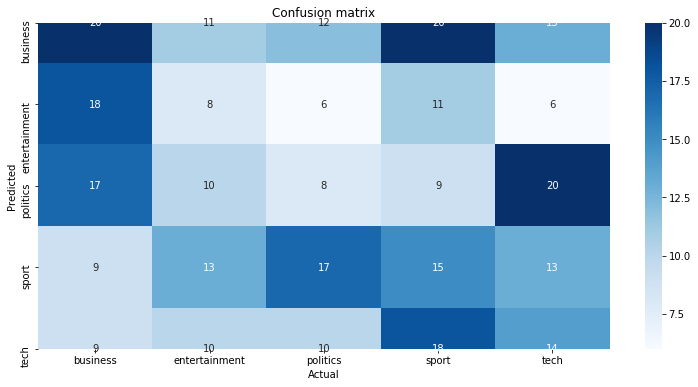

In [19]:
aux_df = df[['Category', 'CategoryCode']].drop_duplicates().sort_values('CategoryCode')
conf_matrix = confusion_matrix(labels_test, lrc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Category'].values, 
            yticklabels=aux_df['Category'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

At this point, we could get the average time the model takes to get predictions. We want the algorithm to be fast since we are creating an app which will gather data from the internet and get the predicted categories. However, since the difference when predicting 10-20 observations will be very little, we won't take this into account.

However, the code below could do this task:

features_time = features_train

elapsed_list = []

for i in range(0,10):

    start = time.time()
    predictions = best_lrc.predict(features_time)
    end = time.time()
    elapsed = end - start
    elapsed_list.append(elapsed)

mean_time_elapsed = np.mean(elapsed_list)

Let's see if the hyperparameter tuning process has returned a better model:

In [20]:
base_model = LogisticRegression(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.19873817034700317

In [21]:
best_lrc.fit(features_train, labels_train)
accuracy_score(labels_test, best_lrc.predict(features_test))

0.20504731861198738

We get approximately the same accuracy.

We'll create a dataset with a model summary to compare models:

In [22]:
d = {
     'Model': 'Logistic Regression',
     'Training Set Accuracy': accuracy_score(labels_train, best_lrc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, lrc_pred)
}

df_models_lrc = pd.DataFrame(d, index=[0])
df_models_lrc

,Model,Training Set Accuracy,Test Set Accuracy
0,Logistic Regression,0.664811,0.205047


Let's save the model and this dataset:

In [23]:
with open('Models/best_lrc.pickle', 'wb') as output:
    pickle.dump(best_lrc, output)
    
with open('Models/df_models_lrc.pickle', 'wb') as output:
    pickle.dump(df_models_lrc, output)